# Exploratory Data Analysis 6
Let's make pretty plots from the first-order network data.

In [214]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import signac

project = signac.get_project()
job = project.find_jobs({"year": 2011, "quarter": 1}).next()

In [2]:
G = nx.read_weighted_edgelist(job.fn('all_edges.tsv'), create_using=nx.DiGraph())

In [3]:
pos = nx.spring_layout(G)  # positions for all nodes
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
log_weights = np.log(weights)
log_weights /= np.max(log_weights)

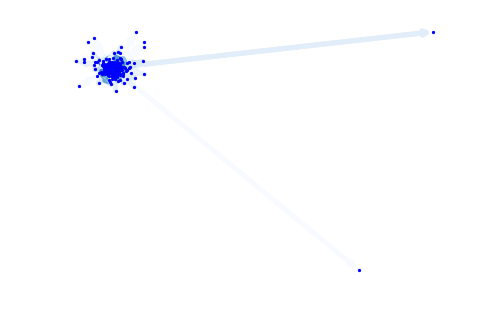

In [4]:
nx.draw(G, pos, node_color='b', node_size=5, edgelist=edges, edge_color=log_weights, width=5, edge_cmap=plt.cm.Blues)

IATA data was obtained from: https://datahub.io/core/airport-codes

In [5]:
if not project.isfile('airport_geodata.csv'):
    import urllib.request
    url = 'https://datahub.io/core/airport-codes/r/airport-codes.csv'
    urllib.request.urlretrieve(url, project.fn('airport_geodata.csv'))

In [164]:
geodata = pd.read_csv(project.fn('airport_geodata.csv'))
geodata = geodata.dropna(subset=['iata_code'])
geodata = geodata[geodata['iso_country'] == 'US']
geodata = geodata[['name', 'iata_code', 'coordinates']].set_index('iata_code')
coords = geodata['coordinates'].str.split(', ', expand=True)
geodata['lon'] = pd.to_numeric(coords[0])
geodata['lat'] = pd.to_numeric(coords[1])
geodata = geodata.drop(columns=['coordinates'])

# Ignore airports with erroneous data near (0, 0)
geodata = geodata[geodata.lon < -65]

# Drop data for Alaska and Hawaii
geodata = geodata[geodata.lon > -130]

In [165]:
iatas = pd.read_csv(job.fn('airport_codes.csv'))
iatas['ID'] = pd.to_numeric(iatas['ID'])
iatas = iatas.set_index('ID')
pageranks = pd.DataFrame.from_dict(nx.pagerank(G), orient='index')
pageranks.columns = ['PageRank']
pageranks.index = pd.to_numeric(pageranks.index)
iatas = iatas.join(pageranks)

In [185]:
airports = pd.merge(iatas, geodata, left_on='IATA', right_index=True)
airports['PageRankPercentile'] = airports['PageRank'].rank(pct=True)

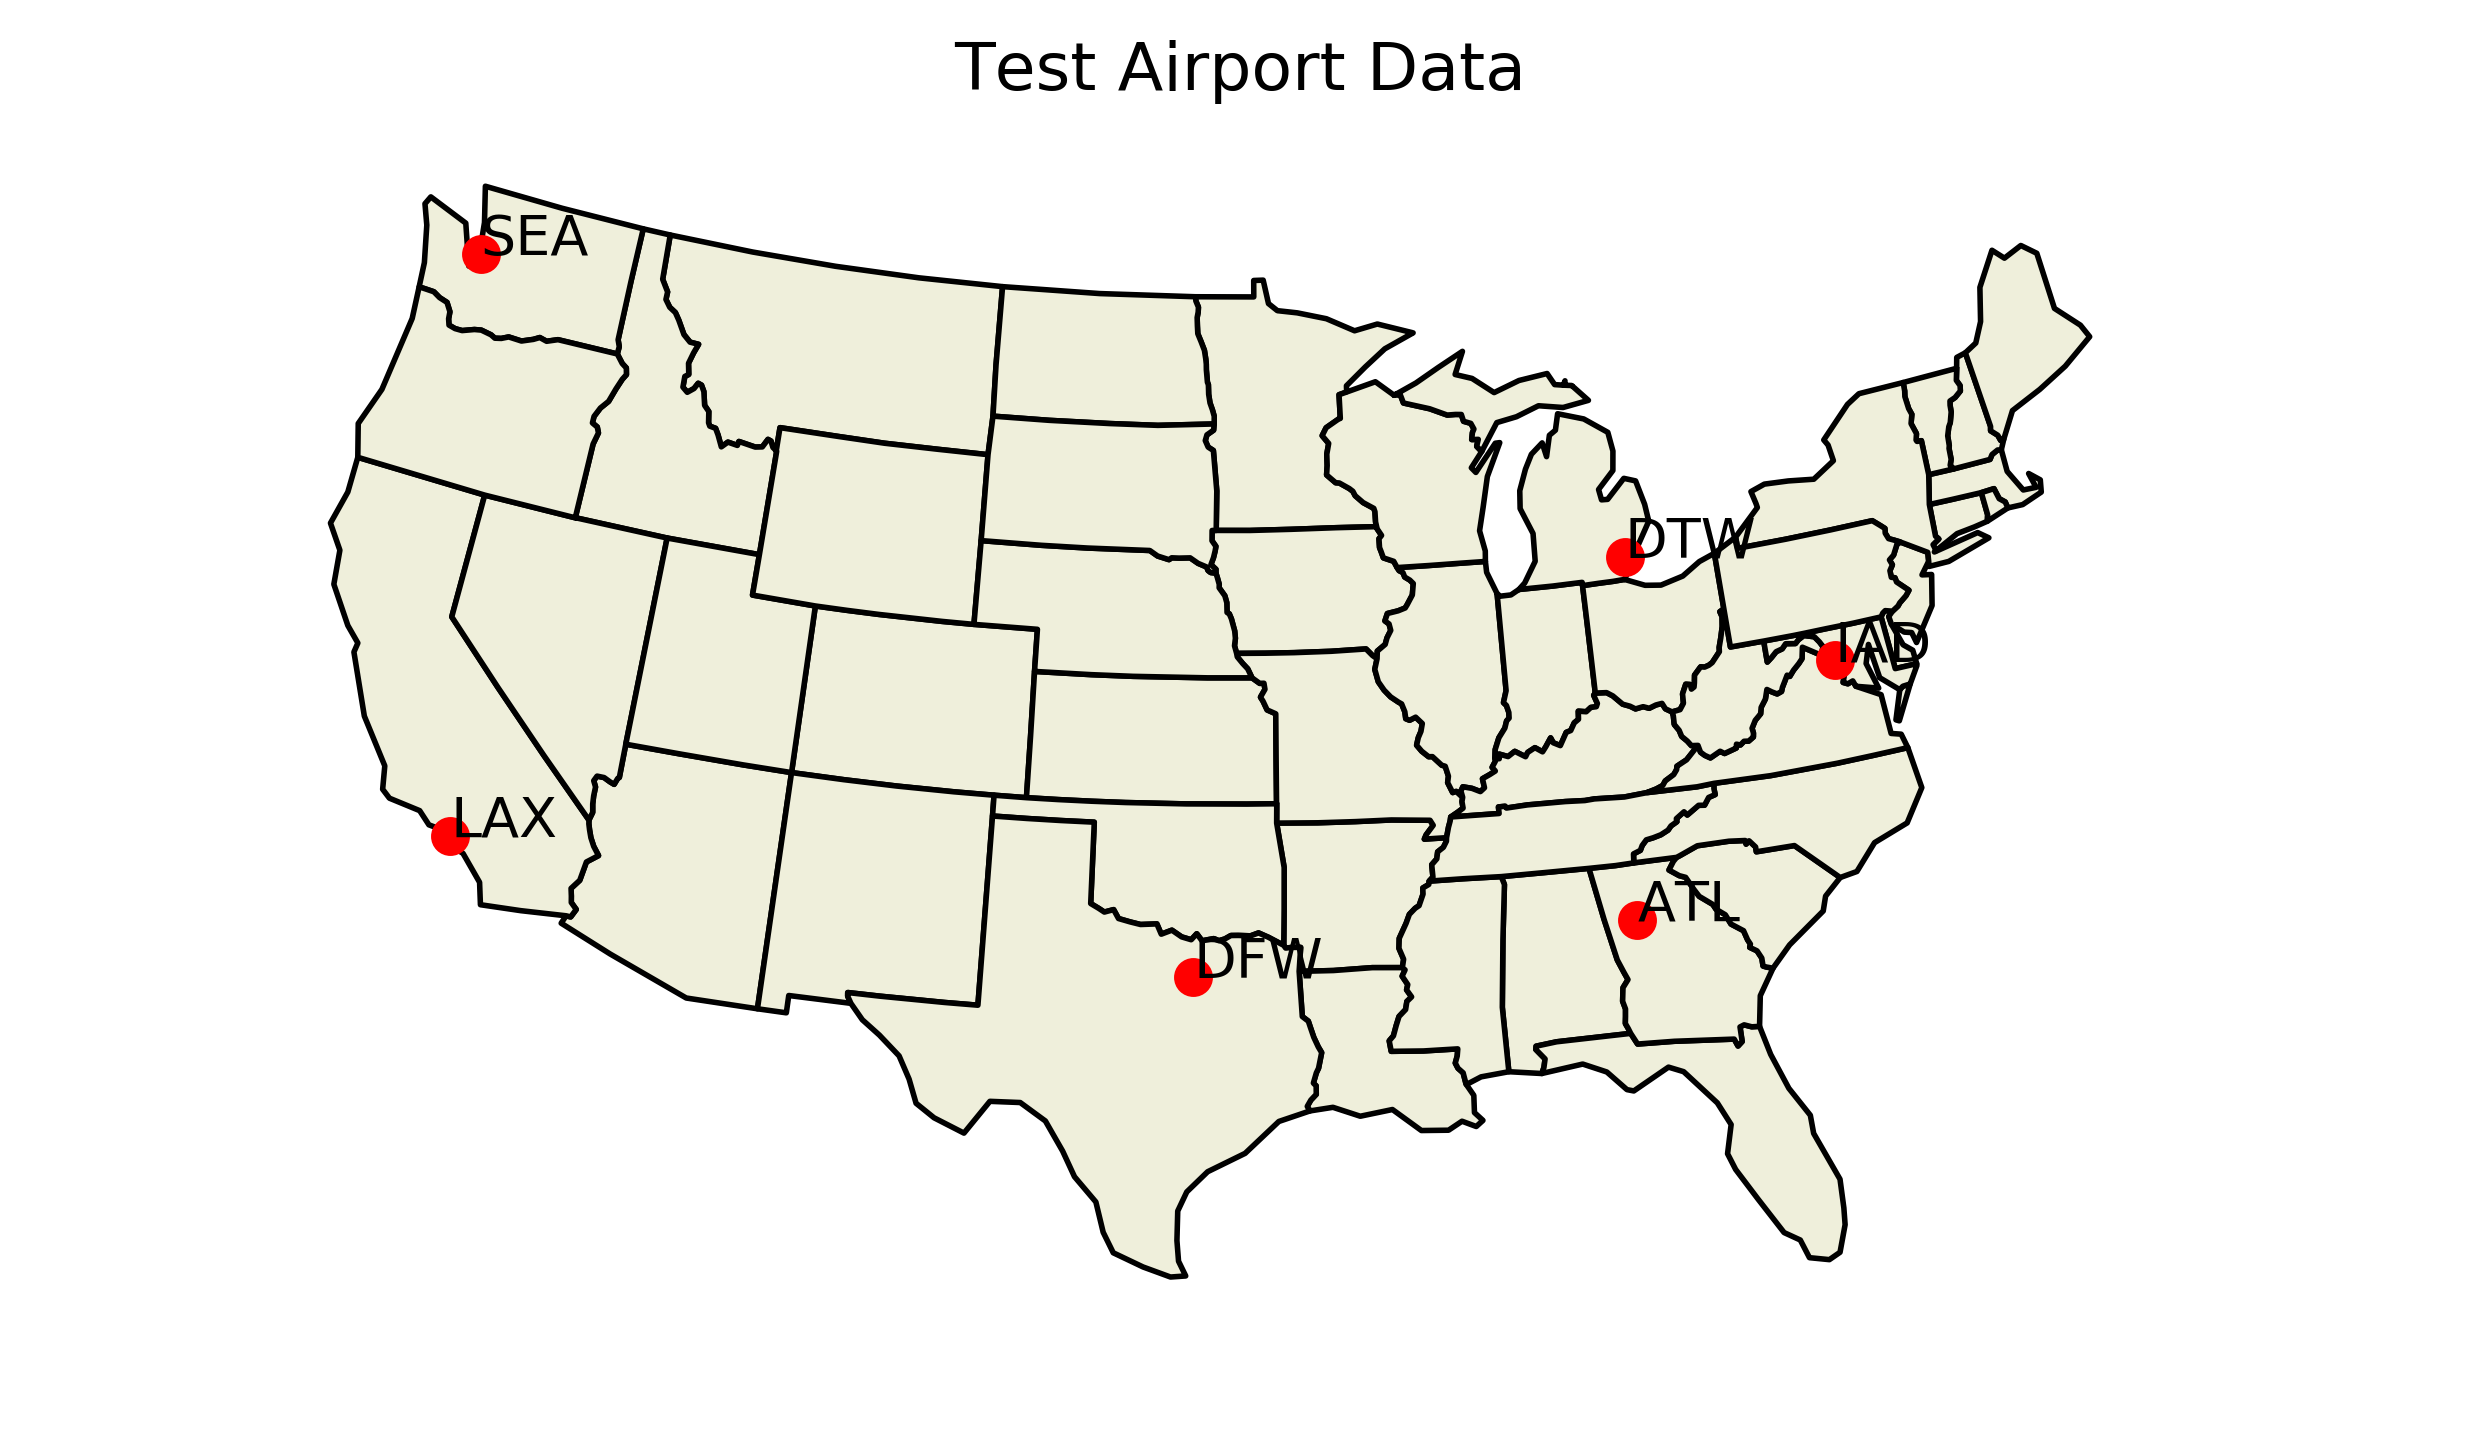

In [167]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader


fig = plt.figure(figsize=(6, 4), dpi=400)
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_title('Test Airport Data')

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.8594)
    return {'facecolor': facecolor, 'edgecolor': 'black'}

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=colorize_state)

data = geodata.loc[['DTW', 'SEA', 'IAD', 'ATL', 'DFW', 'LAX']]
xs = data.lon.values
ys = data.lat.values
ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='red', zorder=10)

for row in data.itertuples():
    ax.annotate(row[0], (row[2], row[3]), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), zorder=11)

plt.show()

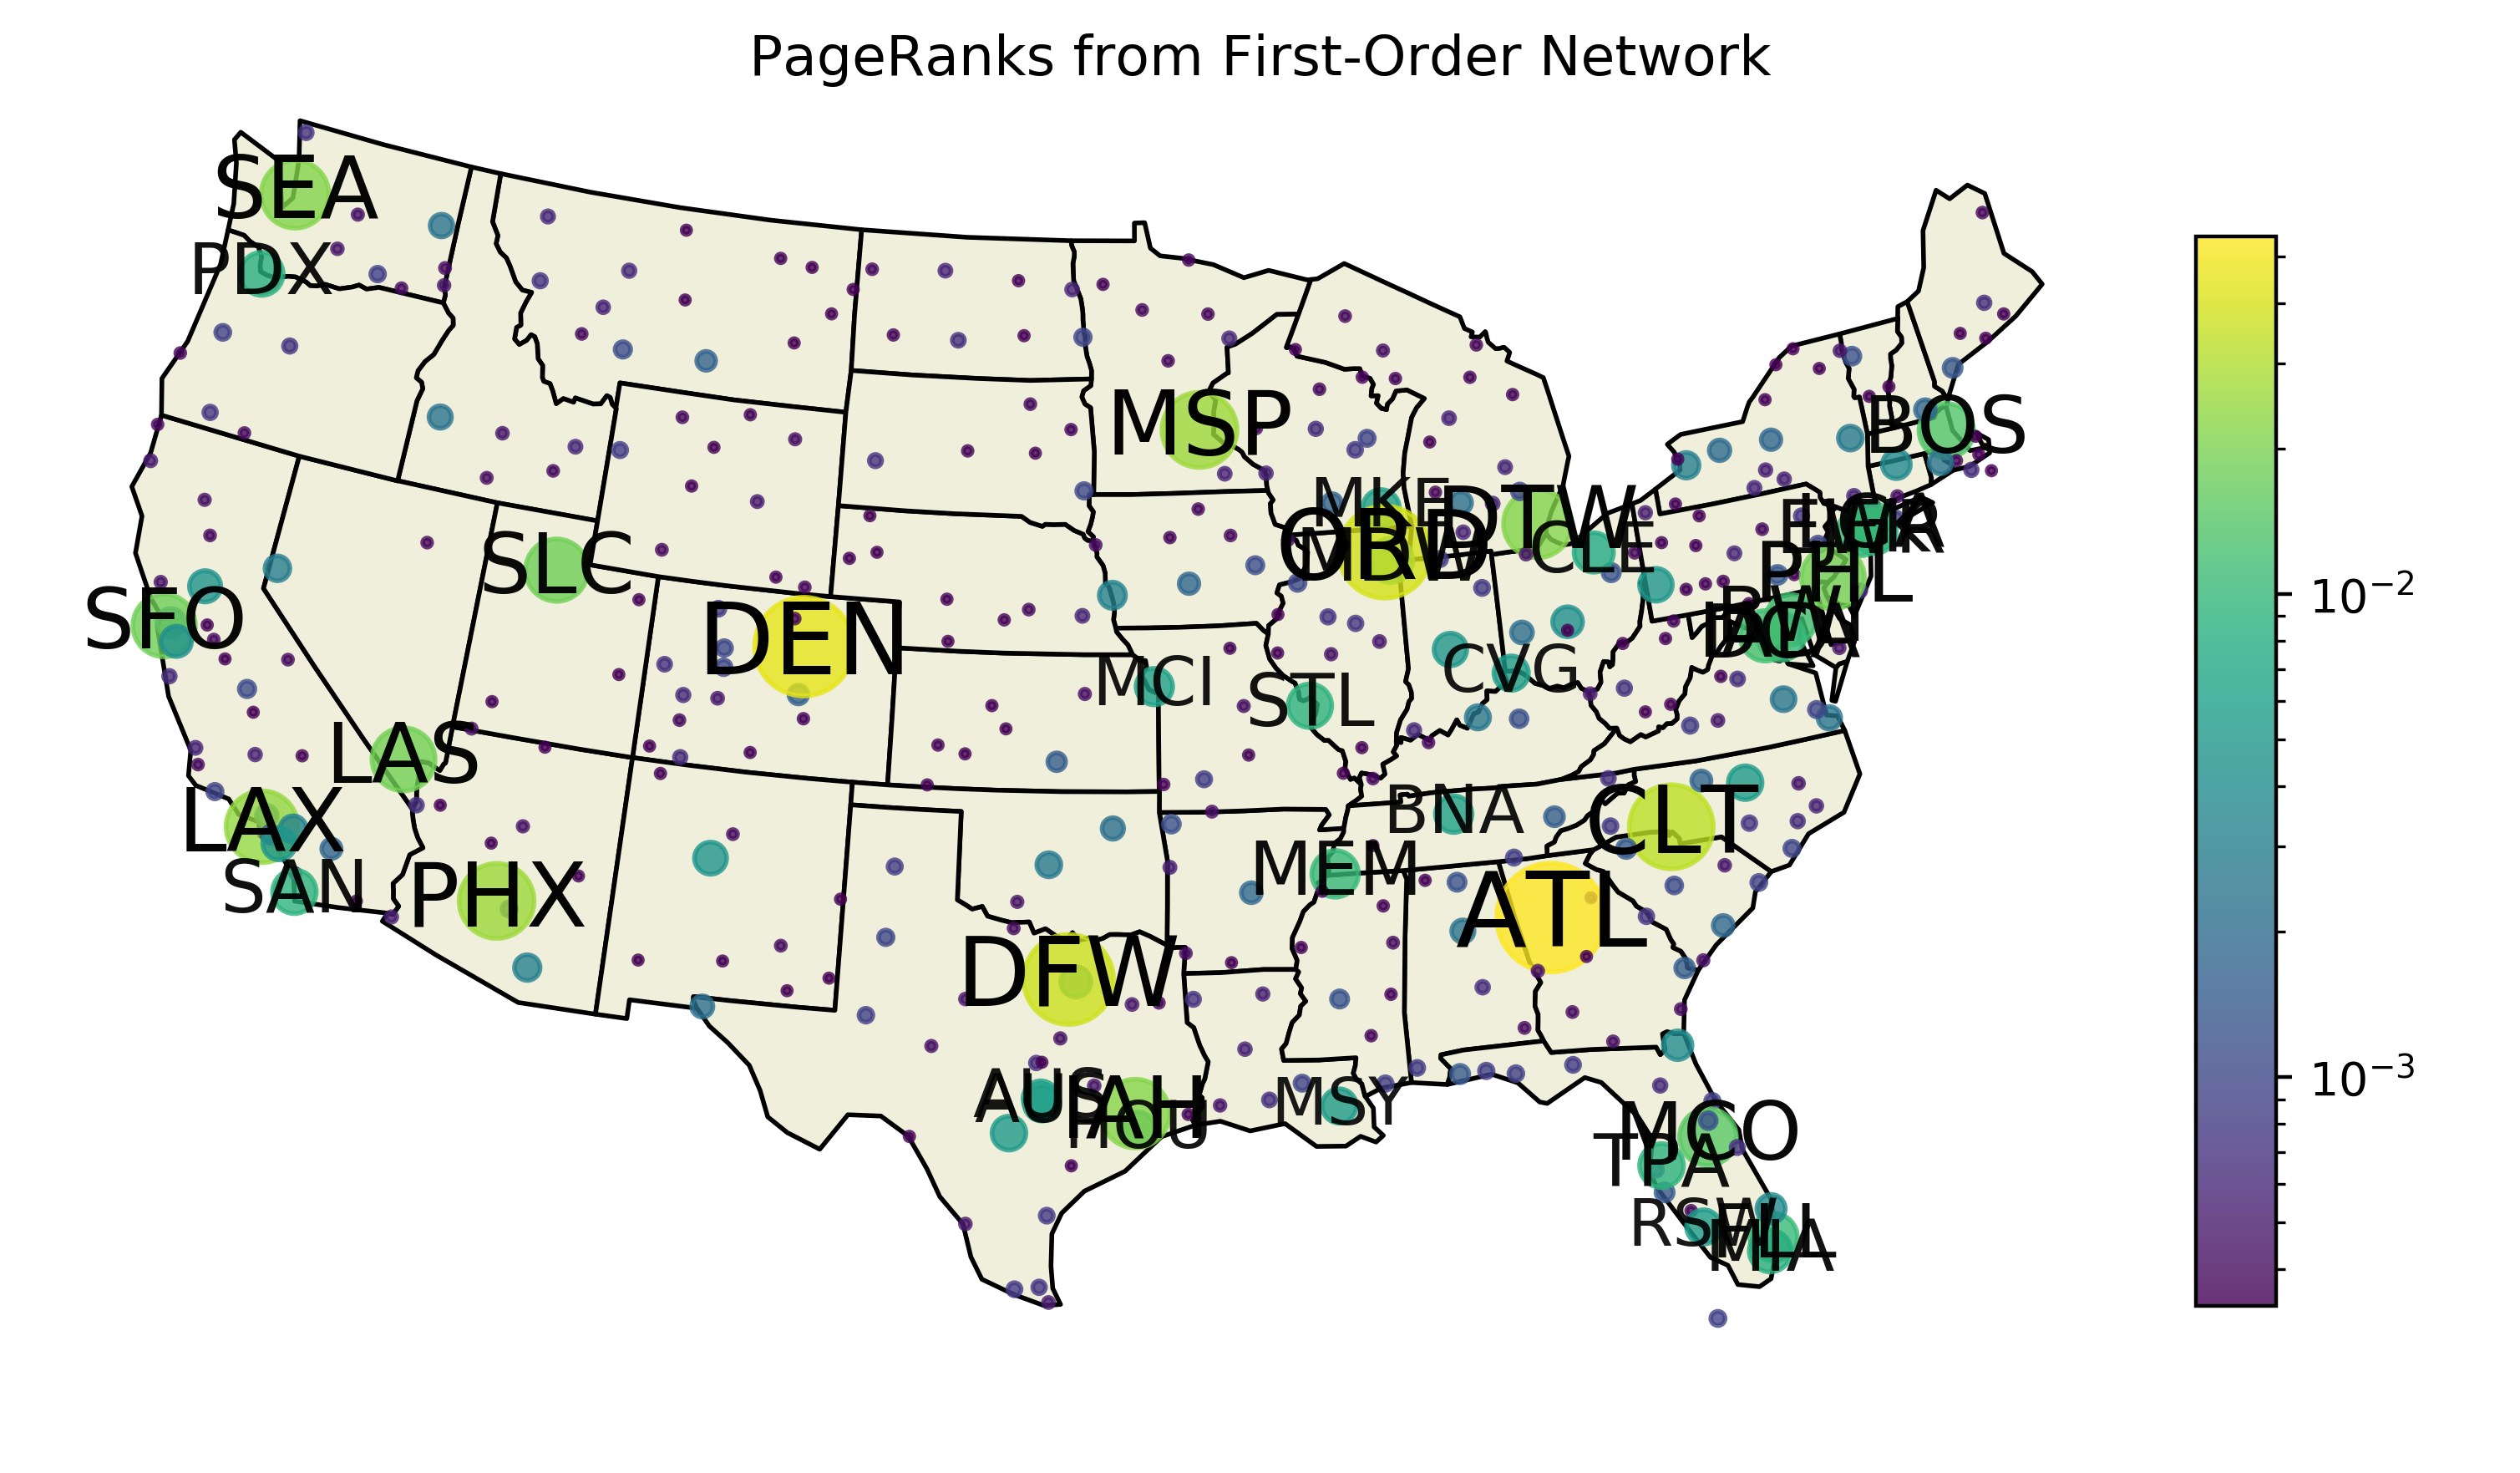

In [239]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader


fig = plt.figure(figsize=(8, 4), dpi=400)
ax = fig.add_axes([0, 0, 2, 1], projection=ccrs.LambertConformal())

ax.set_extent([-120, -65, 20, 48.5], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_title('PageRanks from First-Order Network')

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.8594)
    return {'facecolor': facecolor, 'edgecolor': 'black'}

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=colorize_state)

xs = airports.lon.values
ys = airports.lat.values
colors = airports.PageRank.values
sizes = 10000*airports.PageRank.values

dots = ax.scatter(xs, ys, transform=ccrs.PlateCarree(), c=colors, s=sizes, alpha=0.8, zorder=10,
                  norm=mcolors.LogNorm(vmin=colors.min(), vmax=colors.max()), cmap='viridis')

for row in airports.itertuples():
    if row.PageRankPercentile > 0.90:
        ax.annotate(row.IATA, (row.lon, row.lat), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                    fontsize=40*row.PageRank**0.2, alpha=row.PageRankPercentile, zorder=11,
                    ha='center', va='center')
cbax = fig.add_axes([1.35, 0.1, 0.03, 0.8])
plt.colorbar(dots, cax=cbax)
plt.show()